In [1]:
from astropy.io import ascii
from scipy.optimize import minimize
from scipy import interpolate

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fourier function, Eq. 7 in the paper
def function_fourier_fit(a, t):
    
    ret = a[0] + a[1]*np.sin(2*np.pi*(t)) + a[2]*np.cos(2*np.pi*(t))
    i = 0

    for deg in range(3, len(a),2):
        i+=1
        ret += a[deg]*np.sin(2*(i+1)*np.pi*(t)) + a[deg+1]*np.cos(2*(i+1)*np.pi*(t))

    return ret


# Log-normal distribution
def ln_normal(dy, std):
    return -0.5 * (dy)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

# Data for a given star

In [8]:
# --------- example

time_of_brighness_maxima = 2455197.5 # M0
pulsation_period = 0.53 # per
ampG  = 0.6  # amplitude in G-band
eampG = 0.01 # error on amplitude in G-band

class_star = "RRab"

time_of_observations = np.array([2455197.62, 2455197.642])  # JD
line_of_sight_velocity = np.array([-30.6, -27.22])          # vlos
uncertainty_line_of_sight_velocity = np.array([1.44, 2.32]) # evlos

## Amplitude scaling relation

In [9]:
# Equations 14 and 15 in the paper
scaling_relation_RRab = np.array([39, -133, 159])
scaling_relation_RRc = np.array([62.0])

# Equations 16 and 17 in the paper
covariance_matrix_scaling_relation_RRab = np.array([[ 172, -271, 97], 
                                                    [-271, 438, -163], 
                                                    [97, -163, 64]])

covariance_matrix_scaling_relation_RRc = np.array([4.0]) 

## Template and scatter in template

In [18]:
#                phase   RRab1   RRab2   RRab3    RRc
err = np.array([[0.000 , 0.068 , 0.073 , 0.053 , 0.095],
                [0.025 , 0.068 , 0.073 , 0.053 , 0.095],
                [0.075 , 0.036 , 0.071 , 0.048 , 0.079],
                [0.125 , 0.054 , 0.052 , 0.047 , 0.105],
                [0.175 , 0.051 , 0.049 , 0.058 , 0.062],
                [0.225 , 0.065 , 0.033 , 0.044 , 0.082],
                [0.275 , 0.053 , 0.051 , 0.043 , 0.069],
                [0.325 , 0.069 , 0.047 , 0.039 , 0.064],
                [0.375 , 0.057 , 0.051 , 0.063 , 0.096],
                [0.425 , 0.069 , 0.050 , 0.058 , 0.052],
                [0.475 , 0.053 , 0.048 , 0.032 , 0.086],
                [0.525 , 0.056 , 0.051 , 0.023 , 0.064],
                [0.575 , 0.060 , 0.069 , 0.031 , 0.056],
                [0.625 , 0.057 , 0.055 , 0.110 , 0.061],
                [0.675 , 0.072 , 0.049 , 0.066 , 0.086],
                [0.725 , 0.045 , 0.052 , 0.071 , 0.165],
                [0.775 , 0.058 , 0.068 , 0.039 , 0.121],
                [0.825 , 0.095 , 0.073 , 0.093 , 0.163],
                [0.875 , 0.112 , 0.273 , 0.215 , 0.210],
                [0.925 , 0.218 , 0.172 , 0.036 , 0.091],
                [0.975 , 0.064 , 0.094 , 0.038 , 0.091],
                [1.000 , 0.064 , 0.094 , 0.038 , 0.091]])

In [21]:
# Table 3, first row in the paper
template_fourier_rrab1 = np.array([0.0000, -0.2699, -0.2723, 
                                   -0.0540, -0.1428, 0.0120, 
                                   -0.0955, 0.0402, -0.0493, 
                                   0.0381, -0.0115])

template_fourier_rrab2 = np.array([0.0000, -0.2983, -0.2924, 
                                   -0.0538, -0.1330, -0.0101, 
                                   -0.0931, 0.0419, -0.0642, 
                                   0.0511, -0.0206]) 

template_fourier_rrab3 = np.array([0.0000, -0.2931, -0.2508, 
                                   -0.0772, -0.1432, 0.0057, 
                                   -0.1009, 0.0577, -0.0403, 
                                   0.0386, -0.0041]) 

template_fourier_rrc = np.array([0.0000, -0.1997, -0.3880, 
                                 0.0328, -0.1382, 0.0455, 
                                 -0.0297])

# Table B5, first column in the paper
phase_for_scatter_in_template = err[:,0]

# Table B5, second column in the paper
scatter_in_template_rrab1 = err[:,1]
scatter_in_template_rrab2 = err[:,2]   
scatter_in_template_rrab3 = err[:,3]  
scatter_in_template_rrc   = err[:,4]


# Spline function that interpolates the discrete scatter along the pulsation phase
f_spline_err_rrab1 = interpolate.interp1d(phase_for_scatter_in_template, scatter_in_template_rrab1, kind='linear')
f_spline_err_rrab2 = interpolate.interp1d(phase_for_scatter_in_template, scatter_in_template_rrab2, kind='linear')
f_spline_err_rrab3 = interpolate.interp1d(phase_for_scatter_in_template, scatter_in_template_rrab3, kind='linear')
f_spline_err_rrc   = interpolate.interp1d(phase_for_scatter_in_template, scatter_in_template_rrc, kind='linear')

In [15]:
vector = np.array([ampG**3, ampG**2, ampG])
derivative_vector = np.array([ampG**2, ampG, 1.0])
epsilon_rrab = 5.

Amp_line_of_sight_vel = scaling_relation_RRab @ vector 
uncertainty_Amp_line_of_sight_vel = np.sqrt(vector @ covariance_matrix_scaling_relation_RRab @ vector.T 
                                                    + ((scaling_relation_RRab[:3] @ derivative_vector)**2)*(eampV**2) + epsilon_rrab**2)                                          
        
print(r"Predicted amplitude of the line of sight velocity and its error is: %.1f ± %.1f kms-1" %(Amp_line_of_sight_vel, 
                                                                                           uncertainty_Amp_line_of_sight_vel))

Predicted amplitude of the line of sight velocity and its error is: 55.9 ± 5.1 kms-1


In [22]:
def systematic_velocity_determ(param, HJD, measured_velocity, uncertainty_measured_velocity, 
                               P, M0, Alos, eAlos, template_fourier, f_spline_err):
    
    vsys = param

    # Equation 21 in paper
    phase_star = np.mod(HJD - M0, P) / P
    
    # Equation 19 in paper
    model_velocity = function_fourier_fit(template_fourier, phase_star)*Alos + vsys

    # Equation 20 in paper
    evel_fin = np.sqrt(uncertainty_measured_velocity**2 
                       + (f_spline_err(phase_star)*Alos)**2 
                       + (function_fourier_fit(template_fourier,phase_star)*eAlos)**2 )

    # Equation 18 in paper
    result = ln_normal(measured_velocity - model_velocity, evel_fin) 

    
    return np.nansum(result[np.isfinite(result)])




# Possibility for including some priors
def prior(param):
    # pick a prior
    return 0.0


def LOG_probability(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos, 
                    template_fourier, f_spline_err):
    
    lp = prior(param)
    
    rety = systematic_velocity_determ(param, HJD, measured_velocity, 
                                      uncertainty_measured_velocity, 
                                      P, M0, Alos, eAlos, template_fourier, 
                                      f_spline_err) 

    return lp + rety


def LOG_minus(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos, template_fourier, f_spline_err):
    return -LOG_probability(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos, template_fourier, f_spline_err)

## Using Scipy library

In [23]:
if (class_star == "RRab") and (pulsation_period < 0.55):
    p0 = np.array([-50.])

    
    res = minimize(LOG_minus, x0=p0, args=(time_of_observations, 
                                          line_of_sight_velocity, 
                                          uncertainty_line_of_sight_velocity, 
                                          pulsation_period, 
                                          time_of_brighness_maxima, 
                                          Amp_line_of_sight_vel, 
                                          uncertainty_Amp_line_of_sight_vel, 
                                          template_fourier_rrab1, 
                                          f_spline_err_rrab1), method='BFGS') #SLSQP


    print("Determined systemic velocity and its uncertainty is: %.1f ± %.1f kms-1" %(res.x[0], np.sqrt(np.diag(res.hess_inv))[0]))

elif (class_star == "RRab") and (pulsation_period > 0.55) and (pulsation_period < 0.7):
    
    p0 = np.array([-50.])

    res = minimize(LOG_minus, x0=p0, args=(time_of_observations, 
                                          line_of_sight_velocity, 
                                          uncertainty_line_of_sight_velocity, 
                                          pulsation_period, 
                                          time_of_brighness_maxima, 
                                          Amp_line_of_sight_vel, 
                                          uncertainty_Amp_line_of_sight_vel, 
                                          template_fourier_rrab2, 
                                          f_spline_err_rrab2), method='BFGS') #SLSQP


    print("Determined systemic velocity and its uncertainty is: %.1f ± %.1f kms-1" %(res.x[0], np.sqrt(np.diag(res.hess_inv))[0]))
elif (class_star == "RRab") and (pulsation_period > 0.7):
    
    p0 = np.array([-50.])

    res = minimize(LOG_minus, x0=p0, args=(time_of_observations, 
                                          line_of_sight_velocity, 
                                          uncertainty_line_of_sight_velocity, 
                                          pulsation_period, 
                                          time_of_brighness_maxima, 
                                          Amp_line_of_sight_vel, 
                                          uncertainty_Amp_line_of_sight_vel, 
                                          template_fourier_rrab3, 
                                          f_spline_err_rrab3), method='BFGS') #SLSQP


    print("Determined systemic velocity and its uncertainty is: %.1f ± %.1f kms-1" %(res.x[0], np.sqrt(np.diag(res.hess_inv))[0]))




Determined systemic velocity and its uncertainty is: -20.1 ± 2.8 kms-1


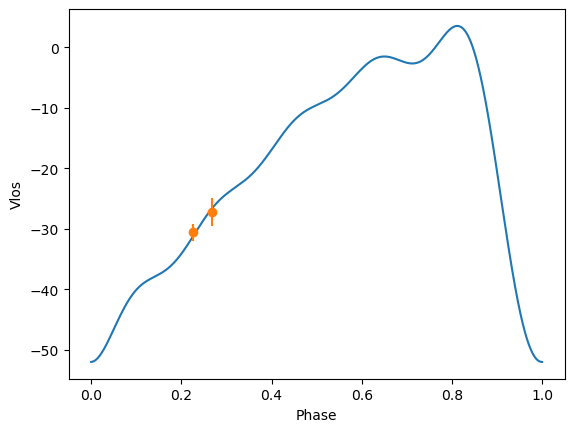

In [24]:
phase_star = np.mod(time_of_observations - time_of_brighness_maxima, pulsation_period) / pulsation_period

phase_star_model = np.linspace(0, 1, 1000)

model_velocity_rrab1 = function_fourier_fit(template_fourier_rrab1, phase_star_model)*Amp_line_of_sight_vel + res.x[0]

plt.plot(phase_star_model, model_velocity_rrab1)
plt.errorbar(phase_star, line_of_sight_velocity, yerr=uncertainty_line_of_sight_velocity, fmt="o")
plt.xlabel("Phase")
plt.ylabel("Vlos")
plt.show()